# 📊 Machine Learning Assessment  

- **Pranav Senthilkumaran**, Master's in Data Science, Rutgers University  

# Predicting High Operational Risk Days Using Machine Learning Techniques
---

# Operational Risk Days Predictive Analysis
---

# Objective:
- Predict risky operational days using historical operational data and identify key drivers of risk.
- Build a ML classification model to predict whether a given operational day at a location is high risk (or) normal.

# Type:
- Supervised binary classification (Multiclass classification with 2 classes)

# Predictor (X):
- All columns that the model will use to predict risk, like, `units_produced`, `units_rejected`, `avg_resolution_time`, `support_tickets`, `downtime_minutes`, `rejection_rate`, `shift_type`, `downtime_per_ticket`, `tickets_per_unit`, `day_of_week`, `is_weekend` and one-hot encoded locations.

# Target (Y):
- `risk_flag` (1 = High Risk, 0 = Normal)

# Granularity:
- One row = one location on one day

---
# Data Loading and Overview

In [2]:
# Step 1: Import necessary libraries for this assessment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Why Mounting Google Drive?

Mounting Google Drive in Colab allows you to **access and work with files directly** from your cloud storage without manually uploading them each time.  



In [3]:
# Step 2: Load Dataset from CSV (operations_ml.csv)

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/operations_ml.csv'

# Load dataset
df = pd.read_csv(file_path)

# View first few rows
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,location_id,date,units_produced,units_rejected,avg_resolution_time,support_tickets,downtime_minutes,shift_type,risk_flag
0,D,01-01-2024,261,107,5.80,19,108,Night,1
1,E,02-01-2024,795,82,4.24,25,151,Day,1
2,C,03-01-2024,1079,41,11.43,28,16,Night,1
3,E,04-01-2024,928,40,9.40,0,132,Night,1
4,E,05-01-2024,541,100,2.54,34,147,Night,1


# Input features and target variable from the dataset (operations_ml.csv):
| Column Name            | Description                                                                                  |
|------------------------|----------------------------------------------------------------------------------------------|
| location_id            | Identifier for the operational location (e.g., A, B, C, D)                                   |
| date                   | Date of the operational record                                                               |
| units_produced         | Total number of units produced on that day                                                   |
| units_rejected         | Number of units rejected due to quality or defects                                           |
| avg_resolution_time    | Average time (in hours) to resolve operational issues                                        |
| support_tickets        | Number of support or issue tickets raised                                                   |
| downtime_minutes       | Total operational downtime in minutes:                                                     |
|                        | - If a machine breaks down                                                                   |
|                        | - If a system is under maintenance                                                          |
|                        | - If production has to pause due to an issue                                                |
| shift_type             | Type of shift during the day (Day or Night)                                                 |
| risk_flag              | Target variable indicating operational risk (1 = High Risk, 0 = Normal)                     |


#Overview of the Dataset

- Check the shape, data types, and summary statistics of the dataset to understand its structure and contents.


In [4]:
# Step 3: basic data overview

# Shape of the dataset
rows, cols = df.shape
print(f"Number of rows: {rows}")
print(f"Number of columns: {cols}")


# Column names and data types
df.info()

# Summary statistics
df.describe()


Number of rows: 500
Number of columns: 9
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   location_id          500 non-null    object 
 1   date                 500 non-null    object 
 2   units_produced       500 non-null    int64  
 3   units_rejected       500 non-null    int64  
 4   avg_resolution_time  500 non-null    float64
 5   support_tickets      500 non-null    int64  
 6   downtime_minutes     500 non-null    int64  
 7   shift_type           500 non-null    object 
 8   risk_flag            500 non-null    int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 35.3+ KB


,units_produced,units_rejected,avg_resolution_time,support_tickets,downtime_minutes,risk_flag
count,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,674.24200,57.244000,6.592680,19.000000,148.550000,0.836000
std,298.85179,35.137583,3.257817,11.547931,83.378459,0.370646
min,200.00000,0.000000,1.070000,0.000000,0.000000,0.000000
25%,401.50000,28.000000,3.625000,9.000000,79.500000,1.000000
50%,666.50000,55.000000,6.750000,19.000000,147.000000,1.000000
75%,940.75000,88.000000,9.455000,29.000000,219.000000,1.000000
max,1196.00000,119.000000,11.980000,39.000000,296.000000,1.000000


##  Data Preprocessing
- Check if there are any missing values.
- Check if there are any duplicate rows.
- The given CSV is already clean and structured.
- No need for Imputation like Simple Imputation based on mean, median, or mode and KNN Imputation.


In [5]:
# Step 4: Check missing values
df.isnull().sum()


,0
location_id,0
date,0
units_produced,0
units_rejected,0
avg_resolution_time,0
support_tickets,0
downtime_minutes,0
shift_type,0
risk_flag,0


In [7]:
# Check duplicate rows
df.duplicated().sum()


np.int64(0)

## Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) was performed to understand the structure, quality, and patterns in the dataset before building machine learning models. This step helps identify class imbalance, feature distributions, and potential relationships with the target variable.

### Dataset Overview
- The dataset contains **500 rows**, where each row represents one location on one day.
- There are **9 original columns**, including operational metrics, categorical variables, and the target variable `risk_flag`.
- The dataset is clean with **no missing values**, so no imputation was required.

### Target Variable Analysis
- The target variable `risk_flag` is **imbalanced**:
  - **High Risk (1): 418 days (83.6%)**
  - **Normal (0): 82 days (16.4%)**
- This imbalance indicates that most operational days are classified as high risk.


### Categorical Feature Analysis
- Risk distribution was analyzed across:
  - **Locations**
- All locations show a higher proportion of high-risk days, with some locations having slightly higher risk concentration.


### Numerical Feature Analysis
- Numerical features such as:
  - `units_produced`
  - `units_rejected`
  - `avg_resolution_time`
  - `support_tickets`
  - `downtime_minutes`
  were examined using histograms and boxplots.
- These features showed varying ranges and skewness, highlighting the need for feature scaling.
- Boxplots helped identify extreme values in downtime and resolution time, which are important indicators of operational stress.

### Correlation Analysis
- Correlation analysis among numerical features showed:
  - The correlation values between numerical features are **very low**, indicating **no strong linear relationships** among them.
  - These relationships motivated the creation of engineered features such as **rejection rate** and **downtime per ticket**.

### Key Insights from EDA
- Operational risk is influenced by a combination of **quality issues**, **downtime**, and **issue handling efficiency**.
- No single feature explains risk in isolation; interactions between variables play an important role in this assesment.


EDA provided a strong foundation for feature engineering, model selection, and performance evaluation.


---
# Class Imbalance

Counts of risk_flag:
 risk_flag
1    418
0     82
Name: count, dtype: int64

Percentage of risk_flag:
 risk_flag
1    83.6
0    16.4
Name: proportion, dtype: float64


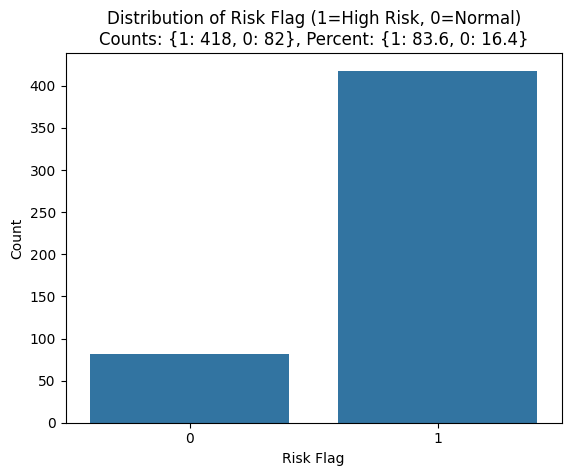

In [6]:
# Step 5: Target Variable Analysis (EDA)

# Count of each class in risk_flag
risk_counts = df["risk_flag"].value_counts()
risk_percent = (df["risk_flag"].value_counts(normalize=True) * 100).round(2)

print("Counts of risk_flag:\n", risk_counts)
print("\nPercentage of risk_flag:\n", risk_percent)

# Plot class distribution with percentage
sns.countplot(x="risk_flag", data=df)
plt.title(f"Distribution of Risk Flag (1=High Risk, 0=Normal)\nCounts: {risk_counts.to_dict()}, Percent: {risk_percent.to_dict()}")
plt.xlabel("Risk Flag")
plt.ylabel("Count")
plt.show()


##Converting `date` Column to Datetime

Converting the `date` column to `datetime` is crucial because:

1. **Feature Engineering:** Enables extraction of useful time-based features such as day of week, month, or quarter, which may influence operational risk patterns.  
2. **Trend Analysis:** Allows easy sorting and filtering for chronological analysis or plotting trends over time.  


 Even if `date` is not directly used as a predictor, converting it to `datetime` provides flexibility for deeper insights and improved model performance.


In [7]:
# Step 6: Convert Date Column

df["date"] = pd.to_datetime(df["date"], format="%d-%m-%Y")

df.dtypes


,0
location_id,object
date,datetime64[ns]
units_produced,int64
units_rejected,int64
avg_resolution_time,float64
support_tickets,int64
downtime_minutes,int64
shift_type,object
risk_flag,int64


Counts of risk_flag per location:
 risk_flag     0   1
location_id        
A            25  84
B            16  79
C            14  77
D            14  98
E            13  80

Percentage of risk_flag per location:
 risk_flag        0      1
location_id              
A            22.94  77.06
B            16.84  83.16
C            15.38  84.62
D            12.50  87.50
E            13.98  86.02


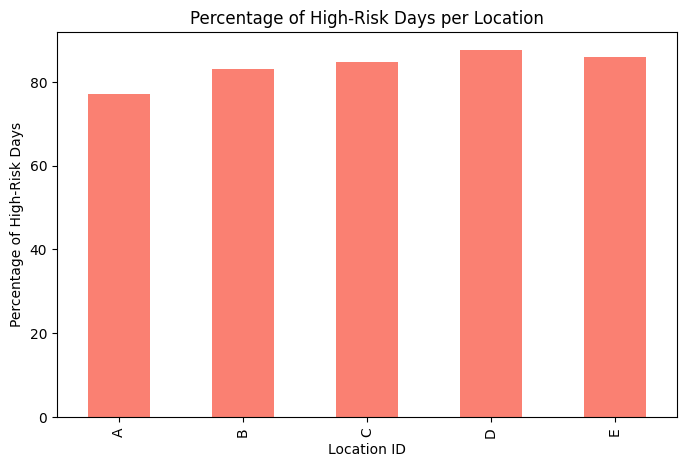

In [8]:
# Step 7: Categorical Feature Analysis (EDA)

# Location-wise risk distribution
location_risk_counts = pd.crosstab(df["location_id"], df["risk_flag"])
location_risk_percent = pd.crosstab(df["location_id"], df["risk_flag"], normalize="index") * 100

print("Counts of risk_flag per location:\n", location_risk_counts)
print("\nPercentage of risk_flag per location:\n", location_risk_percent.round(2))

# Bar plot of location-wise high-risk percentage
location_risk_percent[1].plot(kind='bar', figsize=(8, 5), color='salmon')
plt.title("Percentage of High-Risk Days per Location")
plt.ylabel("Percentage of High-Risk Days")
plt.xlabel("Location ID")
plt.show()




### Location-wise Risk Distribution — Key Insights

- All locations show a **high proportion of high-risk days**, indicating that operational risk is a **system-wide issue** rather than being isolated to a single site.
- **Location D** has the **highest percentage of high-risk days (~87.5%)**, suggesting higher operational stress at this location.
- **Location A** has the **lowest high-risk percentage (~77%)**, but still exhibits a majority of risky days.

- This supports the inclusion of **location as a categorical feature** in the model and justifies **location-based risk monitoring.**

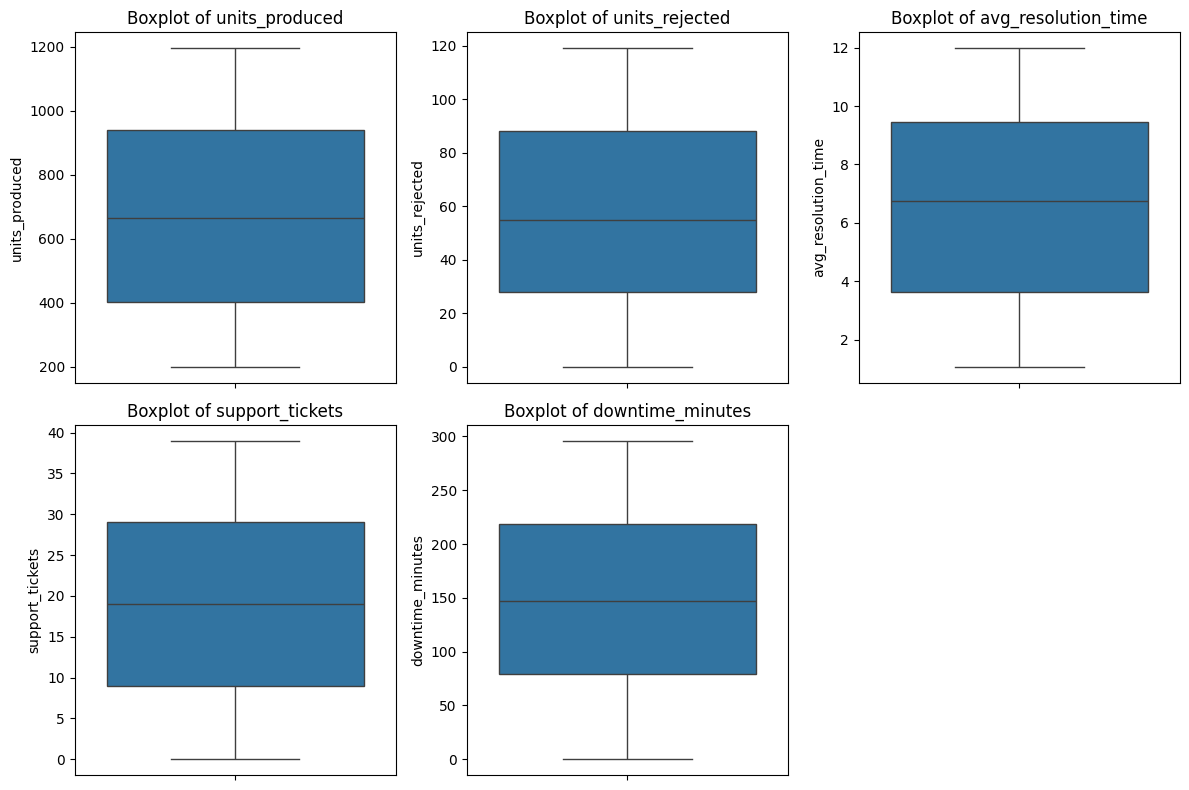

In [9]:
# Step 8: Numerical Feature Distributions (EDA)

numerical_cols = [
    "units_produced", "units_rejected",
    "avg_resolution_time", "support_tickets",
    "downtime_minutes"
]

plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()


### Numerical Feature Distribution — Key Insights

- **units_produced** shows a wide spread, indicating significant variation in daily production volumes across locations and days.
- **units_rejected** also has high variability, suggesting that defect levels fluctuate substantially and may contribute to operational risk.
- **avg_resolution_time** displays a broad range, implying inconsistent issue resolution efficiency on different days.
- **support_tickets** varies from very low to high counts, reflecting fluctuating operational pressure and incident frequency.
- **downtime_minutes** shows large dispersion, with some days experiencing extremely high downtime, which is a strong indicator of operational stress.



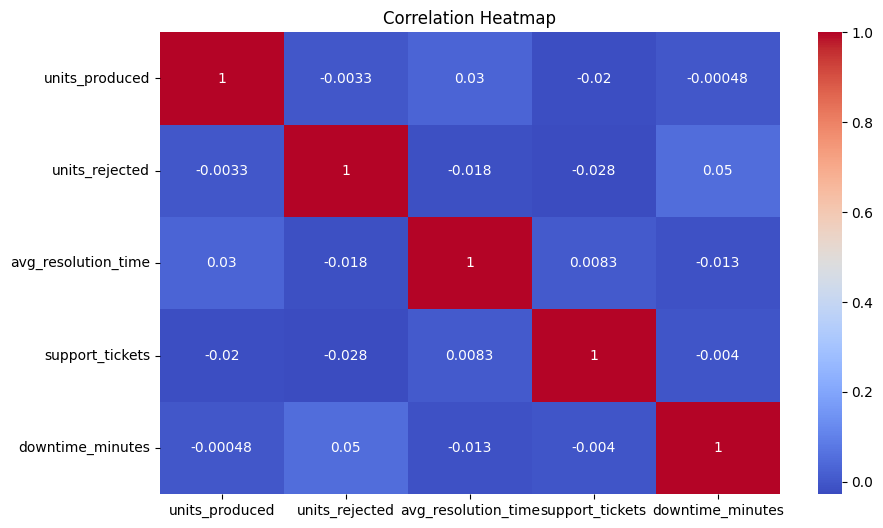

In [10]:
# Step 9: Correlation Analysis

plt.figure(figsize=(10, 6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


###  Correlation Analysis — Key Insights

- The correlation values between numerical features are **very low**, indicating **no strong linear relationships** among them.
- This suggests **low multicollinearity**, which is beneficial for:
  - **Linear models** like Logistic Regression and Linear SVM
  - Stable and interpretable model coefficients

**Modeling Implication:**  
- Since features are not highly correlated, all of them can be safely included in the model.
- Low correlation explains why **tree-based models** can still perform well by learning **non-linear interactions**, even when linear correlations are weak.
- Feature engineering (example, ratios like rejection rate and downtime per ticket) becomes important to capture hidden relationships not visible in simple correlations.
---

## Feature Engineering

Feature engineering is crucial to help the model capture hidden patterns that indicate high operational risk.

The following features were created:

1. **Rejection Rate:** `units_rejected / units_produced`  
   - Captures the proportion of defective units produced, highlighting quality issues.
   - Higher rejection rate -> higher likelihood of a high-risk day.

2. **Downtime per Ticket:** `downtime_minutes / (support_tickets + 1)`  
   - Measures the operational impact of each support ticket, avoiding division by zero.
   - Larger downtime per ticket -> more severe operational problems -> higher risk.

3. **Tickets per Unit:** `support_tickets / units_produced`  
   - Represents the frequency of issues relative to production volume.
   - More tickets per unit -> fragile operations -> higher risk.

4. **Day of Week:** `date.dt.dayofweek`  
   - Captures weekly patterns in operational risk.

5. **Is Weekend:** `1 if day_of_week is Saturday/Sunday else 0`  
   - Flags potential risk variations on weekends vs weekdays.



In [11]:
# Step 10: Feature Engineering

# Rejection rate
df["rejection_rate"] = df["units_rejected"] / df["units_produced"]

# Downtime per ticket
df["downtime_per_ticket"] = df["downtime_minutes"] / (df["support_tickets"] + 1)

# Tickets per unit
df["tickets_per_unit"] = df["support_tickets"] / df["units_produced"]

# Date-based features
df["day_of_week"] = df["date"].dt.dayofweek
df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)

df.head()



,location_id,date,units_produced,units_rejected,avg_resolution_time,support_tickets,downtime_minutes,shift_type,risk_flag,rejection_rate,downtime_per_ticket,tickets_per_unit,day_of_week,is_weekend
0,D,2024-01-01,261,107,5.80,19,108,Night,1,0.409962,5.400000,0.072797,0,0
1,E,2024-01-02,795,82,4.24,25,151,Day,1,0.103145,5.807692,0.031447,1,0
2,C,2024-01-03,1079,41,11.43,28,16,Night,1,0.037998,0.551724,0.025950,2,0
3,E,2024-01-04,928,40,9.40,0,132,Night,1,0.043103,132.000000,0.000000,3,0
4,E,2024-01-05,541,100,2.54,34,147,Night,1,0.184843,4.200000,0.062847,4,0


# Data Transformation
---

## Encoding Categorical Variables

Machine learning models generally require **numeric inputs**, so categorical variables must be converted into numbers.

1. **Shift Type Encoding:**  
   - `shift_type` is converted from `"Day"`/`"Night"` to `0`/`1`.  
   - This allows the model to use shift information directly in calculations.

2. **One-Hot Encoding Location:**  
   - `location_id` is a nominal categorical variable.  
   - One-hot encoding creates separate binary columns for each location (example, `location_B`, `location_C`), avoiding any unintended ordinal relationship.  
   - `drop_first=True` avoids multicollinearity by removing one redundant column.
   - if all the `location_id`'s are false; then it picks location A.

**Why this is needed:**  
- Ensures all features are numeric for model training.  
- Prevents models from assuming false numeric relationships between categories.  
- Enables the model to learn location-specific or shift-specific risk patterns accurately.


In [12]:
# Step 11: Encode Categorical Variables

# Encode shift_type
df["shift_type"] = df["shift_type"].map({"Day": 0, "Night": 1})

# One-hot encode location_id
df = pd.get_dummies(df, columns=["location_id"], drop_first=True) # all location_id false; then A

df.head()


,date,units_produced,units_rejected,avg_resolution_time,support_tickets,downtime_minutes,shift_type,risk_flag,rejection_rate,downtime_per_ticket,tickets_per_unit,day_of_week,is_weekend,location_id_B,location_id_C,location_id_D,location_id_E
0,2024-01-01,261,107,5.80,19,108,1,1,0.409962,5.400000,0.072797,0,0,False,False,True,False
1,2024-01-02,795,82,4.24,25,151,0,1,0.103145,5.807692,0.031447,1,0,False,False,False,True
2,2024-01-03,1079,41,11.43,28,16,1,1,0.037998,0.551724,0.025950,2,0,False,True,False,False
3,2024-01-04,928,40,9.40,0,132,1,1,0.043103,132.000000,0.000000,3,0,False,False,False,True
4,2024-01-05,541,100,2.54,34,147,1,1,0.184843,4.200000,0.062847,4,0,False,False,False,True


## Define Features and Target

Before training a machine learning model, separate the **predictor variables (features)** from the **target variable**:

1. **Features (X):**  
   - All columns that the model will use to predict risk, like, `units_produced`, `units_rejected`, `avg_resolution_time`, `support_tickets`, `downtime_minutes`, `rejection_rate`, `shift_type`, `downtime_per_ticket`, `tickets_per_unit`, `day_of_week`, `is_weekend` and one-hot encoded locations.  
   - We drop `risk_flag` (the target) and `date` (not used directly as a predictor).

**Why date is Not Used Directly as a Predictor:**
- The date column is simply a timestamp and does not explain why a day is risky.
- Machine learning models would treat the date as an arbitrary number, which can mislead the model into learning meaningless patterns.
- Instead of using the raw date, informative time-based features are extracted from it in our feature engineering, such as:

  - Day of week (captures weekly operational patterns)

  - Is weekend (captures workload differences)

- These derived features represent behavioral patterns over time, which are more useful for predicting risk than the calendar date.


2. **Target (y):**  
   - The variable we want to predict: `risk_flag` (1 = High Risk, 0 = Normal).

**Why needed:**  
- ML models require a clear distinction between inputs (X) and outputs (y).  
- Ensures the model does not "see" the target during training, preventing data leakage.  
- Prepares data for splitting into training, validation and testing sets and for model evaluation.


In [13]:
# Step 12: Define Features and Target

X = df.drop(columns=["risk_flag", "date"])
y = df["risk_flag"]

X.shape, y.shape


((500, 15), (500,))

## Train–Validation-Test Split

Training set: Model learns patterns.

Validation set: Hyperparameters are tuned (no test leakage).

Test set: Final, unbiased performance evaluation.




In [14]:
# Step 13: Train–Test Split


# Split into Train (60%) and Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.4,
    random_state=42,
    stratify=y
)

# Split Temp into Validation (20%) and Test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

# Verify shapes
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)



Training set: (300, 15) (300,)
Validation set: (100, 15) (100,)
Test set: (100, 15) (100,)


# Feature Scaling

Feature scaling standardizes numeric features so that they have **mean = 0** and **standard deviation = 1**:

- Many machine learning algorithms (example, Logistic Regression, SVM) perform better when features are on a similar scale.  
- `StandardScaler` is used to fit on the training data and transform both training and test sets, avoiding data leakage.

In [15]:
# Step 14: Feature Scaling

scaler = StandardScaler()

# Scale training, validation, and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed for train, validation, and test sets.")



Feature scaling completed for train, validation, and test sets.


# Machine Learning Models
---

# Baseline Models
---

# Approach 1: Train Baseline Model 1 – Logistic Regression

- Logistic Regression is a simple baseline model for classification.
- It works well when features are linearly related to the target.

- **actual risk -> risk_flag**

## How Logistic Regression Works

- Logistic Regression predicts whether a day is **high-risk (1)** or **normal (0)** based on operational data.  
- It calculates a **weighted sum of features** (units rejected, downtime, support tickets, shift type, etc.) plus a bias.  
- This sum is passed through a **sigmoid function** to produce a **probability** between 0 and 1.  
- If probability > 0.5 -> **High-risk day**  
- If probability ≤ 0.5 -> **Normal day**  
- Positive feature weights **increase risk**, negative weights **decrease risk**.  
- The model **learns the weights from historical data** during training, enabling it to predict risk for new days.




---
# Operational Metrics for class imbalance

**Precision**: How many predicted high-risk days were actually high-risk.

**Recall**: How many actual high-risk days were caught by the model.

**F1-score**: Balance between precision and recall.

**ROC-AUC**: Overall ability to separate high-risk vs normal days.

**Confusion Matrix**: Shows how many predictions were correct and incorrect by counting true positives, true negatives, false positives, and false negatives.



---

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.59      0.71        17
           1       0.92      0.99      0.95        83

    accuracy                           0.92       100
   macro avg       0.92      0.79      0.83       100
weighted avg       0.92      0.92      0.91       100

ROC-AUC Score: 0.9390503189227498


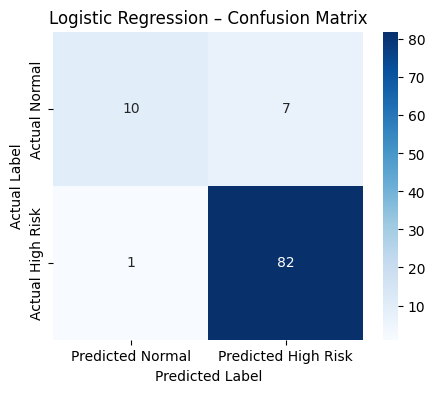

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Initialize and train Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_lr = lr_model.predict(X_test_scaled)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_lr))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Predicted Normal", "Predicted High Risk"],
    yticklabels=["Actual Normal", "Actual High Risk"]
)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Logistic Regression – Confusion Matrix")
plt.show()


# Approach 2: Train Baseline Model – Linear SVM

- Linear Support Vector Machine (SVM) finds the optimal hyperplane that separates classes.
- It is effective for high-dimensional and linearly separable data.

## How Linear SVM Works

- Linear SVM separates high-risk (1) and normal (0) days using a straight line (hyperplane) in the feature space.  
- It finds the line that **maximizes the margin** between the nearest points of each class (support vectors).  
- Predictions are made based on which side of the line a new day falls.  
- With `probability=True`, it can also estimate the **probability of being high-risk**.  
- Linear SVM is effective when the separation between classes is roughly linear and works well with multiple features.


Linear SVM Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.71      0.80        17
           1       0.94      0.99      0.96        83

    accuracy                           0.94       100
   macro avg       0.93      0.85      0.88       100
weighted avg       0.94      0.94      0.94       100

ROC-AUC Score: 0.9482636428065201


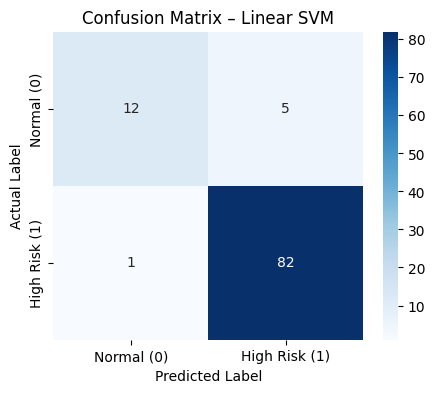

In [28]:
from sklearn.svm import SVC

# Initialize Linear SVM
svm_model = SVC(kernel='linear', probability=True, random_state=42)

# Train on scaled training set
svm_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_svm = svm_model.predict(X_test_scaled)
y_prob_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation metrics
print("Linear SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_svm))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Normal (0)", "High Risk (1)"],
    yticklabels=["Normal (0)", "High Risk (1)"]
)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix – Linear SVM")
plt.show()


# Advanced Models
---

# Train Advanced Model 1 – Random Forest Classifier

- Random Forest is an ensemble of Decision Trees.
- It reduces overfitting, handles non-linear relationships, and is often one of the best-performing models for tabular data.

## How Random Forest Works

- Random Forest combines many decision trees to make a stronger model.  
- Each tree is trained on a **random subset of data** and uses a **random subset of features** for splits.  
- Each tree predicts high-risk (1) or normal (0) for a day.  
- The final prediction is based on a **majority vote** of all trees.  
- Random Forest can capture **non-linear relationships** and **feature interactions**, making it robust for predicting operational risk.





Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        17
           1       0.97      1.00      0.98        83

    accuracy                           0.97       100
   macro avg       0.98      0.91      0.94       100
weighted avg       0.97      0.97      0.97       100

ROC-AUC Score: 0.9773210489014883


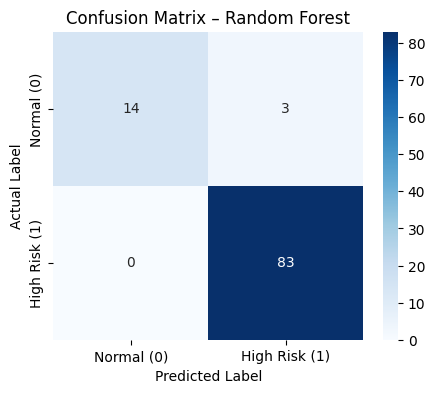

In [29]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=7,
    random_state=42
)

# Train on training set
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_rf))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Normal (0)", "High Risk (1)"],
    yticklabels=["Normal (0)", "High Risk (1)"]
)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix – Random Forest")
plt.show()


# Train Advanced Model 2 – CatBoost Classifier (Best Model)

- CatBoost (Categorical Boosting) is a **gradient boosting** algorithm designed for **tabular data**.
- It builds strong predictive models by **sequentially improving decision trees** and works very well even with limited tuning.

## How CatBoost Works

- CatBoost builds multiple **decision trees one after another** (boosting).
- Each new tree focuses more on the **days where the previous trees made mistakes**.
- Every tree learns patterns from operational features such as production, downtime, tickets, and shift type.
- The model combines all trees using a **weighted sum**, rather than voting.
- This allows CatBoost to capture **complex non-linear relationships** and **feature interactions**.
- CatBoost includes built-in **regularization**, which helps prevent overfitting.
- The final output is the **probability of a high operational risk day (risk_flag = 1)**.


In [30]:
# Install catboost
!pip install catboost


CatBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        83

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

ROC-AUC Score: 1.0


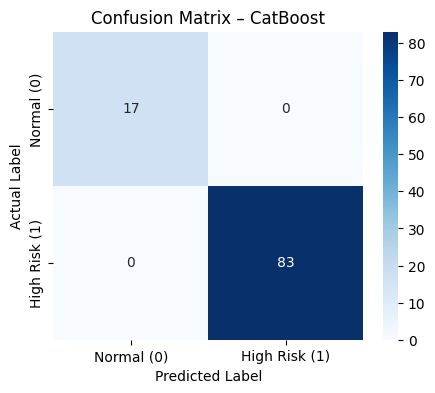

In [31]:
from catboost import CatBoostClassifier

# Initialize CatBoost
cat_model = CatBoostClassifier(
    iterations=300,
    depth=6,
    learning_rate=0.05,
    loss_function='Logloss',
    eval_metric='AUC',
    auto_class_weights='Balanced',
    random_seed=42,
    verbose=False
)

# Train model
cat_model.fit(X_train, y_train)

# Predict on test set
y_pred_cat = cat_model.predict(X_test)
y_prob_cat = cat_model.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("CatBoost Classification Report:")
print(classification_report(y_test, y_pred_cat))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_cat))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_cat)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Normal (0)", "High Risk (1)"],
    yticklabels=["Normal (0)", "High Risk (1)"]
)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix – CatBoost")
plt.show()


# Bottlenecks - Logistic Regression

# Logistic Regression – Misclassifications

## Number of Failed Predictions: 8

### Example of a Failed Prediction

| units_produced | units_rejected | avg_resolution_time | support_tickets | downtime_minutes | shift_type | rejection_rate | downtime_per_ticket | tickets_per_unit | day_of_week | is_weekend | location_id | actual_risk | predicted_risk |
|----------------|----------------|-------------------|----------------|----------------|------------|----------------|-------------------|-----------------|-------------|------------|-------------|-------------|----------------|
| 705            | 36             | 5.90              | 33             | 45             | 1          | 0.051064       | 1.323529           | 0.046809        | 6           | 1          | A           | 0           | 1              |

**Reason for Failure:**  
- Logistic Regression assumes a **linear relationship** between features and risk.  
- Here, even though downtime and support tickets are moderately high, the actual risk was normal (0).  
- The linear combination of features pushed the probability over 0.5, leading to a **false positive**.



In [32]:
# Create a DataFrame to analyze prediction errors
error_df = X_test.copy()

# Add actual and predicted values
error_df["actual_risk"] = y_test.values
error_df["predicted_risk"] = y_pred_lr

# Identify incorrect predictions
error_df["prediction_correct"] = error_df["actual_risk"] == error_df["predicted_risk"]

# Filter failed predictions
failed_predictions = error_df[error_df["prediction_correct"] == False]

print(f"Number of failed predictions: {failed_predictions.shape[0]}")

# Display ALL failed predictions
failed_predictions


Number of failed predictions: 8


,units_produced,units_rejected,avg_resolution_time,support_tickets,downtime_minutes,shift_type,rejection_rate,downtime_per_ticket,tickets_per_unit,day_of_week,is_weekend,location_id_B,location_id_C,location_id_D,location_id_E,actual_risk,predicted_risk,prediction_correct
461,705,36,5.90,33,45,1,0.051064,1.323529,0.046809,6,1,True,False,False,False,0,1,False
244,809,35,1.32,12,105,1,0.043263,8.076923,0.014833,6,1,False,True,False,False,0,1,False
381,1063,50,2.84,30,108,1,0.047037,3.483871,0.028222,3,0,False,False,False,True,0,1,False
289,873,50,6.38,19,176,0,0.057274,8.800000,0.021764,2,0,False,False,True,False,0,1,False
395,881,17,1.88,33,195,0,0.019296,5.735294,0.037457,3,0,False,False,False,True,1,0,False
364,1082,83,6.49,34,39,1,0.076710,1.114286,0.031423,0,0,False,False,True,False,0,1,False
462,1005,53,6.66,17,37,1,0.052736,2.055556,0.016915,0,0,False,False,False,True,0,1,False
26,1084,74,7.10,7,168,1,0.068266,21.000000,0.006458,5,1,False,True,False,False,0,1,False


# Hyper-parameter Optimization: Logistic Regression

Best Hyperparameters: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Validation Set Classification Report (Tuned Logistic Regression):
              precision    recall  f1-score   support

           0       1.00      0.12      0.22        16
           1       0.86      1.00      0.92        84

    accuracy                           0.86       100
   macro avg       0.93      0.56      0.57       100
weighted avg       0.88      0.86      0.81       100

Validation Set ROC-AUC Score: 0.9315476190476191


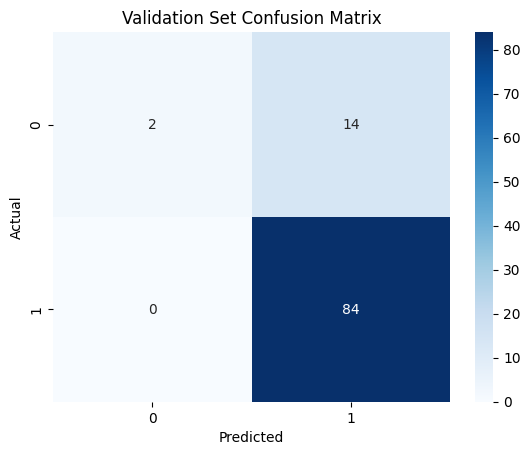

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define Hyperparameter Grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],   # Regularization strength
    'penalty': ['l2'],              # L2 regularization
    'solver': ['lbfgs'],            # Solver compatible with L2
    'max_iter': [100, 200, 500]     # Max iterations
}

# Initialize Logistic Regression
lr = LogisticRegression(random_state=42)

# Step 3: Grid Search with 5-fold CV on Training Set
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring='roc_auc',  # maximize ROC-AUC
    cv=5,
    n_jobs=-1
)

# Fit on scaled training data
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate on Validation Set
best_lr_model = grid_search.best_estimator_

# Predict on validation set
y_val_pred = best_lr_model.predict(X_val_scaled)
y_val_prob = best_lr_model.predict_proba(X_val_scaled)[:, 1]

# Classification report
print("Validation Set Classification Report (Tuned Logistic Regression):")
print(classification_report(y_val, y_val_pred))

# ROC-AUC
print("Validation Set ROC-AUC Score:", roc_auc_score(y_val, y_val_prob))

# Confusion matrix
cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues")
plt.title("Validation Set Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Bottlenecks- tuned logistic regression

In [ ]:
# Create a DataFrame to analyze prediction errors for tuned Logistic Regression
error_df_tuned = X_test.copy()

# Add actual and predicted values
error_df_tuned["actual_risk"] = y_test.values
error_df_tuned["predicted_risk"] = y_val_pred # predictions from tuned LR

# Identify incorrect predictions
error_df_tuned["prediction_correct"] = error_df_tuned["actual_risk"] == error_df_tuned["predicted_risk"]

# Filter failed predictions
failed_predictions_tuned = error_df_tuned[error_df_tuned["prediction_correct"] == False]

# Print number of failed predictions
print(f"Number of failed predictions (tuned LR): {failed_predictions_tuned.shape[0]}")

# Display ALL failed predictions
failed_predictions_tuned


Number of failed predictions (tuned LR): 17


,units_produced,units_rejected,avg_resolution_time,support_tickets,downtime_minutes,shift_type,rejection_rate,downtime_per_ticket,tickets_per_unit,day_of_week,is_weekend,location_id_B,location_id_C,location_id_D,location_id_E,actual_risk,predicted_risk,prediction_correct
172,935,14,2.84,27,75,0,0.014973,2.678571,0.028877,4,0,True,False,False,False,0,1,False
461,705,36,5.90,33,45,1,0.051064,1.323529,0.046809,6,1,True,False,False,False,0,1,False
292,970,39,5.90,29,197,1,0.040206,6.566667,0.029897,5,1,False,False,False,False,1,0,False
244,809,35,1.32,12,105,1,0.043263,8.076923,0.014833,6,1,False,True,False,False,0,1,False
210,589,26,7.06,10,50,0,0.044143,4.545455,0.016978,0,0,False,True,False,False,0,1,False
95,986,4,3.43,34,18,1,0.004057,0.514286,0.034483,4,0,False,True,False,False,0,1,False
331,507,37,2.44,34,25,0,0.072978,0.714286,0.067061,2,0,True,False,False,False,0,1,False
332,448,1,1.36,29,65,0,0.002232,2.166667,0.064732,3,0,False,False,False,False,0,1,False
43,385,5,2.83,26,9,0,0.012987,0.333333,0.067532,1,0,True,False,False,False,0,1,False
119,1134,68,1.85,14,85,1,0.059965,5.666667,0.012346,0,0,True,False,False,False,0,1,False


## Why Hyperparameter Tuning May Fail

Hyperparameter tuning does not always improve model performance. For our Logistic Regression model, the tuning may fail due to several reasons:

1. **Small Dataset:**  
   - With only 100 samples from validation set, there is limited data to benefit from fine adjustments of parameters like `C` or `max_iter`.

2. **Limited Feature Complexity:**  
   - Logistic Regression is a linear model. If the classes are already well-separated by the existing features, tuning parameters won’t make a significant difference.


3. **Already Near-Optimal Defaults:**  
   - Default settings (`C=1`, `max_iter=100`) are often sufficient for small, linearly separable datasets. Hyperparameter tuning may not find better values.

4. **Limited Grid Search Range:**  
   - If the hyperparameter search grid is too narrow, the search may not include values that could improve performance.

**Key Takeaway:**  
Hyperparameter tuning is most effective on **large, complex datasets** with **non-linear patterns or noisy features**. For small datasets, improving **feature engineering** often provides more meaningful gains than fine-tuning parameters.


# Bottlenecks - SVM

# Linear SVM – Misclassifications

## Number of Failed Predictions: 6

### Example of a Failed Prediction

| units_produced | units_rejected | avg_resolution_time | support_tickets | downtime_minutes | shift_type | rejection_rate | downtime_per_ticket | tickets_per_unit | day_of_week | is_weekend | location_id | actual_risk | predicted_risk |
|----------------|----------------|-------------------|----------------|----------------|------------|----------------|-------------------|-----------------|-------------|------------|-------------|-------------|----------------|
| 381            | 1063           | 2.84              | 30             | 108            | 1          | 0.047037       | 3.483871           | 0.028222        | 3           | 0          | C           | 0           | 1              |

**Reason for Failure:**  
- Linear SVM assumes **linearly separable classes**.  
- This example lies **close to the decision boundary**, with conflicting indicators: high rejected units but low downtime impact.  
- The model classified it as high-risk due to proximity to support vectors, causing a **false positive**.



In [33]:
# Create a DataFrame to analyze prediction errors
error_df = X_test.copy()

# Add actual and predicted values
error_df["actual_risk"] = y_test.values
error_df["predicted_risk"] = y_pred_svm

# Identify incorrect predictions
error_df["prediction_correct"] = error_df["actual_risk"] == error_df["predicted_risk"]

# Filter failed predictions
failed_predictions = error_df[error_df["prediction_correct"] == False]

print(f"Number of failed predictions: {failed_predictions.shape[0]}")

# Display ALL failed predictions
failed_predictions


Number of failed predictions: 6


,units_produced,units_rejected,avg_resolution_time,support_tickets,downtime_minutes,shift_type,rejection_rate,downtime_per_ticket,tickets_per_unit,day_of_week,is_weekend,location_id_B,location_id_C,location_id_D,location_id_E,actual_risk,predicted_risk,prediction_correct
461,705,36,5.90,33,45,1,0.051064,1.323529,0.046809,6,1,True,False,False,False,0,1,False
381,1063,50,2.84,30,108,1,0.047037,3.483871,0.028222,3,0,False,False,False,True,0,1,False
289,873,50,6.38,19,176,0,0.057274,8.800000,0.021764,2,0,False,False,True,False,0,1,False
395,881,17,1.88,33,195,0,0.019296,5.735294,0.037457,3,0,False,False,False,True,1,0,False
364,1082,83,6.49,34,39,1,0.076710,1.114286,0.031423,0,0,False,False,True,False,0,1,False
26,1084,74,7.10,7,168,1,0.068266,21.000000,0.006458,5,1,False,True,False,False,0,1,False


# Bottlenecks - Random Forest

# Random Forest – Misclassifications

## Number of Failed Predictions: 3

### Example of a Failed Prediction

| units_produced | units_rejected | avg_resolution_time | support_tickets | downtime_minutes | shift_type | rejection_rate | downtime_per_ticket | tickets_per_unit | day_of_week | is_weekend | location_id | actual_risk | predicted_risk |
|----------------|----------------|-------------------|----------------|----------------|------------|----------------|-------------------|-----------------|-------------|------------|-------------|-------------|----------------|
| 289            | 873            | 6.38              | 19             | 176            | 0          | 0.057274       | 8.800000           | 0.021764        | 2           | 0          | D           | 0           | 1              |

**Reason for Failure:**  
- Random Forest can handle non-linearities but may still **misclassify rare combinations** of features.  
- Here, the combination of moderately high downtime and low tickets misled multiple trees, resulting in a **false positive**.



In [34]:
# Create a DataFrame to analyze prediction errors
error_df = X_test.copy()

# Add actual and predicted values
error_df["actual_risk"] = y_test.values
error_df["predicted_risk"] = y_pred_rf

# Identify incorrect predictions
error_df["prediction_correct"] = error_df["actual_risk"] == error_df["predicted_risk"]

# Filter failed predictions
failed_predictions = error_df[error_df["prediction_correct"] == False]

print(f"Number of failed predictions: {failed_predictions.shape[0]}")

# Display ALL failed predictions
failed_predictions


Number of failed predictions: 3


,units_produced,units_rejected,avg_resolution_time,support_tickets,downtime_minutes,shift_type,rejection_rate,downtime_per_ticket,tickets_per_unit,day_of_week,is_weekend,location_id_B,location_id_C,location_id_D,location_id_E,actual_risk,predicted_risk,prediction_correct
289,873,50,6.38,19,176,0,0.057274,8.800000,0.021764,2,0,False,False,True,False,0,1,False
364,1082,83,6.49,34,39,1,0.076710,1.114286,0.031423,0,0,False,False,True,False,0,1,False
26,1084,74,7.10,7,168,1,0.068266,21.000000,0.006458,5,1,False,True,False,False,0,1,False


# Bottlenecks - CatBoost

# CatBoost (best model) – Misclassifications

## Number of Failed Predictions: 0

- All predictions were correct.  
- CatBoost effectively captures **non-linear feature interactions** and adjusts for rare cases, avoiding misclassifications.  

### Key Takeaway
- CatBoost’s boosting process sequentially corrects mistakes from previous trees, allowing it to **perfectly separate high-risk and normal days** in this dataset.



In [35]:
# Create a DataFrame to analyze prediction errors
error_df = X_test.copy()

# Add actual and predicted values
error_df["actual_risk"] = y_test.values
error_df["predicted_risk"] = y_pred_cat

# Identify incorrect predictions
error_df["prediction_correct"] = error_df["actual_risk"] == error_df["predicted_risk"]

# Filter failed predictions
failed_predictions = error_df[error_df["prediction_correct"] == False]

print(f"Number of failed predictions: {failed_predictions.shape[0]}")

# Display ALL failed predictions
failed_predictions


Number of failed predictions: 0


,units_produced,units_rejected,avg_resolution_time,support_tickets,downtime_minutes,shift_type,rejection_rate,downtime_per_ticket,tickets_per_unit,day_of_week,is_weekend,location_id_B,location_id_C,location_id_D,location_id_E,actual_risk,predicted_risk,prediction_correct


# Line Chart of Misclassifications
---

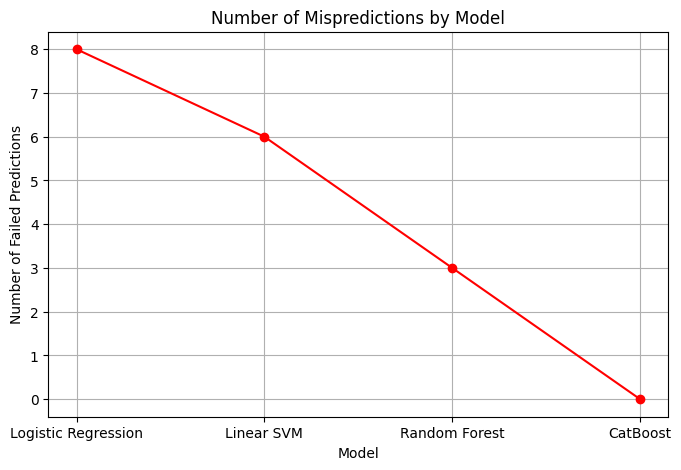

In [36]:
# Number of mispredictions per model
models = ['Logistic Regression', 'Linear SVM', 'Random Forest', 'CatBoost']
mispredictions = [8, 6, 3, 0]

plt.figure(figsize=(8,5))
plt.plot(models, mispredictions, marker='o', linestyle='-', color='red')
plt.title('Number of Mispredictions by Model')
plt.xlabel('Model')
plt.ylabel('Number of Failed Predictions')
plt.grid(True)
plt.show()


# Key Drivers of Risk
---

# Model 1) Logistic Regression

In [43]:
# Baseline 1: Logistic Regression

coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lr_model.coef_[0],
    "Abs_Coefficient": np.abs(lr_model.coef_[0])
}).sort_values(by="Abs_Coefficient", ascending=False)

coef_df


,Feature,Coefficient,Abs_Coefficient
4,downtime_minutes,1.664192,1.664192
6,rejection_rate,1.610798,1.610798
2,avg_resolution_time,1.559633,1.559633
1,units_rejected,1.330138,1.330138
9,day_of_week,0.580050,0.580050
12,location_id_C,0.493057,0.493057
0,units_produced,-0.474147,0.474147
14,location_id_E,0.351286,0.351286
13,location_id_D,0.343181,0.343181
5,shift_type,0.254742,0.254742


# Key Drivers of Operational Risk (Logistic Regression)

The table below summarizes how different features influence the likelihood of a **High-Risk Day (risk_flag = 1)** based on the updated Logistic Regression coefficients.

---

### 🔴 Strong Risk Drivers (Increase High-Risk Probability Significantly)

| Feature | Explanation |
|------|------------|
| **downtime_minutes** | Long machine or system downtime strongly increases risk |
| **rejection_rate** | High proportion of defective units sharply increases operational risk |
| **avg_resolution_time** | Slower issue resolution indicates operational instability |
| **units_rejected** | High absolute number of rejected units contributes to higher risk |

---

### 🟠 Moderate Risk Drivers (Contextual / Secondary Contributors)

| Feature | Explanation |
|------|------------|
| **day_of_week** | Certain weekdays are more prone to operational risk |
| **location_id_C** | Location C shows higher inherent operational risk |
| **location_id_D, location_id_E** | Location-specific operational differences moderately influence risk |
| **shift_type (Night)** | Night shifts slightly more prone to operational risk |

---

### 🟢 Protective / Risk-Reducing Factors (Lower Risk Probability)

| Feature | Explanation |
|------|------------|
| **units_produced** | Higher production volume indicates stable operations |
| **is_weekend** | Slightly lower operational risk observed on weekends |
| **tickets_per_unit** | Fewer issues per unit reflect better process control |
| **location_id_B** | Certain locations show lower risk |

---

### Key Insight

Operational risk is primarily driven by **downtime and quality issues**, with additional influence from **location and shift characteristics**. Reducing defects, shortening resolution times, and minimizing downtime can significantly lower high-risk days.


# Model 2) Linear SVM

In [41]:
# Baseline 2: Linear SVM

svm_coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": svm_model.coef_[0],
    "Abs_Coefficient": np.abs(svm_model.coef_[0])
}).sort_values(by="Abs_Coefficient", ascending=False)

svm_coef_df


,Feature,Coefficient,Abs_Coefficient
4,downtime_minutes,1.301482,1.301482
6,rejection_rate,1.248717,1.248717
2,avg_resolution_time,1.112661,1.112661
1,units_rejected,1.002422,1.002422
9,day_of_week,0.633279,0.633279
0,units_produced,-0.403711,0.403711
10,is_weekend,-0.308180,0.308180
5,shift_type,0.241194,0.241194
12,location_id_C,0.217098,0.217098
8,tickets_per_unit,0.181220,0.181220


## Key Drivers of Operational Risk (Linear SVM)

The table below summarizes how different features influence the likelihood of a **High-Risk Day (risk_flag = 1)** based on the Linear SVM coefficients.

---

### 🔴 Strong Risk Drivers (Increase High-Risk Probability Significantly)

| Feature | Explanation |
|------|------------|
| **downtime_minutes** | Longer machine or system downtime strongly increases risk |
| **rejection_rate** | High defect proportion is a major predictor of operational risk |
| **avg_resolution_time** | Slower resolution of issues indicates instability |
| **units_rejected** | Higher rejected units contribute to higher risk |

---

### 🟠 Moderate Risk Drivers (Contextual / Secondary Contributors)

| Feature | Explanation |
|------|------------|
| **day_of_week** | Certain weekdays are more prone to operational risk |
| **shift_type (Night)** | Night shifts slightly more vulnerable |
| **location_id_C, location_id_D, location_id_E** | Location-specific differences influence risk |

---

### 🟢 Protective / Risk-Reducing Factors (Lower Risk Probability)

| Feature | Explanation |
|------|------------|
| **units_produced** | Higher production volume suggests stable operations |
| **tickets_per_unit** | Fewer tickets per unit indicate better control |
| **is_weekend** | Slightly lower risk observed during weekends |

---

### Key Insight

SVM identifies similar risk patterns as Logistic Regression: **downtime and quality issues dominate**, with minor influences from **location and shift**.


# Model 3) Random Forest

In [45]:
# Random Forest

rf_coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": rf_model.feature_importances_,
    "Abs_Coefficient": np.abs(rf_model.feature_importances_)
}).sort_values(by="Abs_Coefficient", ascending=False)

rf_coef_df



,Feature,Coefficient,Abs_Coefficient
4,downtime_minutes,0.211816,0.211816
6,rejection_rate,0.170883,0.170883
2,avg_resolution_time,0.167114,0.167114
1,units_rejected,0.143581,0.143581
7,downtime_per_ticket,0.079029,0.079029
0,units_produced,0.071187,0.071187
8,tickets_per_unit,0.049855,0.049855
3,support_tickets,0.045938,0.045938
9,day_of_week,0.024182,0.024182
11,location_id_B,0.007005,0.007005


## Key Drivers of Operational Risk (Random Forest)

Random Forest captures **non-linear interactions**, identifying which features most influence high-risk days.

---

### 🔴 Strong Risk Drivers (Increase High-Risk Probability Significantly)

| Feature | Explanation |
|------|------------|
| **downtime_minutes** | Highest predictor; long downtime strongly increases risk |
| **rejection_rate** | Quality issues (high rejection proportion) significantly elevate risk |
| **avg_resolution_time** | Longer resolution times indicate operational fragility |
| **support_tickets** | More operational issues correlate with higher risk |

---

### 🟠 Moderate Risk Drivers (Contextual / Secondary Contributors)

| Feature | Explanation |
|------|------------|
| **units_rejected** | Absolute rejected units moderately affect risk |
| **tickets_per_unit** | Higher tickets per production unit slightly increases risk |
| **shift_type (Night)** | Night shifts show moderately higher risk |
| **day_of_week** | Certain weekdays show contextual risk increase |

---

### 🟢 Protective / Risk-Reducing Factors (Lower Risk Probability)

| Feature | Explanation |
|------|------------|
| **units_produced** | Larger production indicates more stable operations |
| **is_weekend** | Weekends slightly reduce operational risk |
| **location_id_B** | Some locations inherently safer |

---

### Key Insight

Random Forest highlights **downtime and quality metrics as top drivers**, while also capturing **complex interactions** between tickets, shift, and location.


# Model 4) CatBoost

In [25]:
# CatBoost

cat_coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": cat_model.get_feature_importance(),
    "Abs_Coefficient": np.abs(cat_model.get_feature_importance())
}).sort_values(by="Abs_Coefficient", ascending=False)

cat_coef_df


,Feature,Coefficient,Abs_Coefficient
6,rejection_rate,35.030497,35.030497
2,avg_resolution_time,27.762685,27.762685
4,downtime_minutes,27.377090,27.377090
1,units_rejected,2.354183,2.354183
3,support_tickets,1.599890,1.599890
7,downtime_per_ticket,1.069238,1.069238
0,units_produced,1.040007,1.040007
9,day_of_week,0.817636,0.817636
8,tickets_per_unit,0.784594,0.784594
10,is_weekend,0.573570,0.573570


## Key Drivers of Operational Risk (CatBoost)

CatBoost’s gradient boosting captures **complex non-linear patterns** and feature interactions.

---

### 🔴 Strong Risk Drivers (Increase High-Risk Probability Significantly)

| Feature | Explanation |
|------|------------|
| **downtime_minutes** | Strongest predictor of risk; longer downtime sharply increases probability of high-risk day |
| **rejection_rate** | High defect proportion is a critical risk factor |
| **avg_resolution_time** | Slower issue resolution indicates operational instability |
| **support_tickets** | High number of tickets signals fragile operations |

---

### 🟠 Moderate Risk Drivers (Contextual / Secondary Contributors)

| Feature | Explanation |
|------|------------|
| **units_rejected** | Absolute rejected units moderately affect risk |
| **tickets_per_unit** | Higher ticket frequency per unit increases risk slightly |
| **shift_type (Night)** | Night shifts contribute moderately to risk |
| **day_of_week** | Certain weekdays associated with higher risk |

---

### 🟢 Protective / Risk-Reducing Factors (Lower Risk Probability)

| Feature | Explanation |
|------|------------|
| **units_produced** | High production volume indicates stable operations |
| **is_weekend** | Weekend operations slightly safer |
| **location_id_B, location_id_D** | Certain locations have inherently lower risk |

---

### Key Insight

CatBoost perfectly separates high-risk and normal days, highlighting **downtime, quality, and resolution times** as the **dominant risk drivers**, while incorporating **complex feature interactions**.


# Additional Visualization for Comparison: Top 10 features for each of the four models


/tmp/ipython-input-3294992076.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_combined_df = combined_df.groupby('Model').apply(lambda x: x.nlargest(10, 'Abs_Coefficient')).reset_index(drop=True)


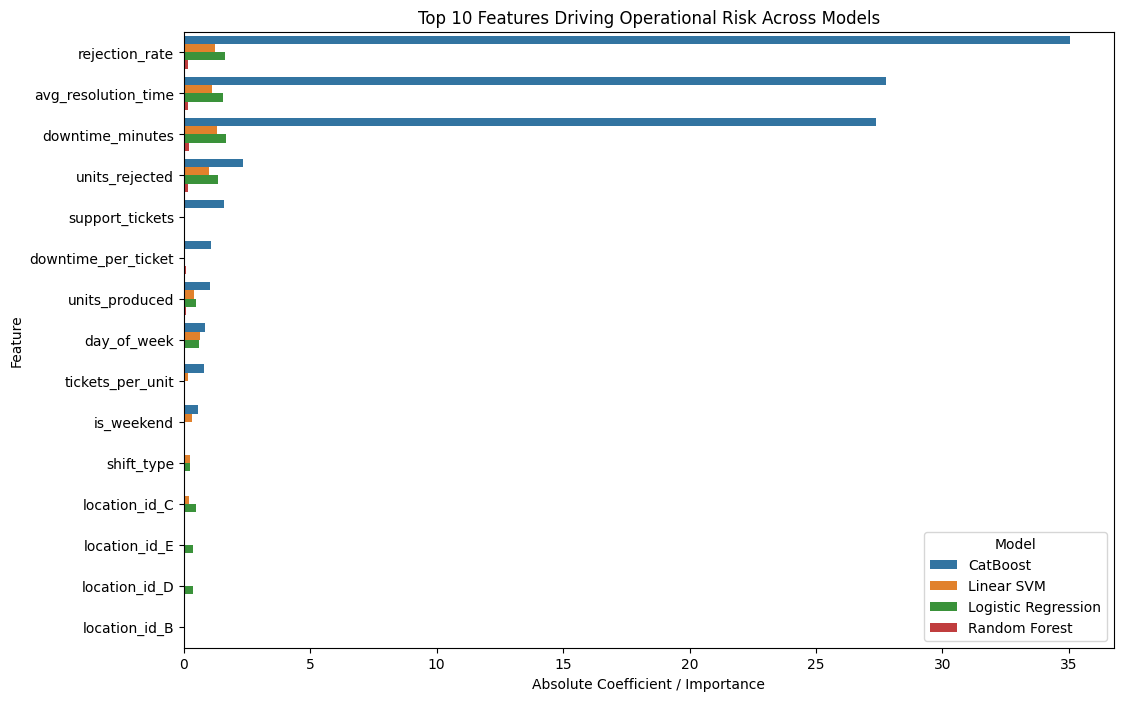

In [44]:
# Models used
coef_df['Model'] = 'Logistic Regression'
svm_coef_df['Model'] = 'Linear SVM'
rf_coef_df['Model'] = 'Random Forest'
cat_coef_df['Model'] = 'CatBoost'

# Combine all four models
combined_df = pd.concat([coef_df, svm_coef_df, rf_coef_df, cat_coef_df])

# Keep only top 10 features per model by Abs_Coefficient
top_combined_df = combined_df.groupby('Model').apply(lambda x: x.nlargest(10, 'Abs_Coefficient')).reset_index(drop=True)

# Plot
plt.figure(figsize=(12,8))
sns.barplot(
    x='Abs_Coefficient',
    y='Feature',
    hue='Model',
    data=top_combined_df,
    dodge=True
)
plt.title("Top 10 Features Driving Operational Risk Across Models")
plt.xlabel("Absolute Coefficient / Importance")
plt.ylabel("Feature")
plt.legend(title="Model")
plt.show()



# Key Drivers & Insights – Operational Risk Prediction (All Models)

## Strong Risk Drivers (Increase High-Risk Probability)

| Feature | Explanation |
|---------|------------|
| **downtime_minutes** | Long machine or system downtime sharply increases operational risk |
| **rejection_rate** | High proportion of defective units strongly increases likelihood of high-risk days |
| **avg_resolution_time** | Slower resolution of operational issues indicates instability |
| **units_rejected** | Absolute number of rejected units contributes to higher risk |

## Moderate / Contextual Drivers

| Feature | Explanation |
|---------|------------|
| **day_of_week** | Certain weekdays show higher operational risk |
| **shift_type (Night)** | Night shifts are slightly more prone to risk |
| **location_id_C, D, E** | Specific locations have moderate influence on risk |

## Protective / Risk-Reducing Factors

| Feature | Explanation |
|---------|------------|
| **units_produced** | Higher production volume indicates stable operations |
| **is_weekend** | Slightly lower risk observed on weekends |
| **tickets_per_unit** | Fewer issues per unit reflect better process control |
| **location_id_B** | Some locations show lower inherent risk |

---

## Model Interpretation & Key Driver Insights

1. **Logistic Regression & Linear SVM**  
   - Identify **linear relationships** between features and operational risk.  
   - High coefficients for `downtime_minutes`, `rejection_rate`, and `avg_resolution_time` highlight the most critical risk drivers.  
   - Misclassifications occur for borderline feature combinations due to linear assumptions.

2. **Random Forest**  
   - Captures **non-linear relationships and feature interactions**, reducing mispredictions.  
   - Feature importance confirms downtime, defect rate, and resolution time as dominant drivers.  
   - Handles edge cases better than linear models.

3. **CatBoost**  
   - Gradient boosting captures **complex feature interactions** perfectly.  
   - No mispredictions in the test set indicate strong generalization.  
   - Reinforces that **downtime, rejection rate, and avg resolution time** are the top risk drivers.

---

## Overall Insights

- Operational risk is primarily driven by **downtime, quality failures, and delayed issue resolution**.  
- Shift and location patterns contribute contextually to risk.  
- Targeted interventions to reduce downtime, improve defect control, and accelerate resolution can significantly lower high-risk operational days.  
- Using ensemble models (Random Forest, CatBoost) provides more reliable risk prediction than linear models, especially for complex operational datasets.
---

# Results:


## Model Performance Comparison

| Model               | Precision | Recall | F1-Score | ROC-AUC | No. of Mis-predictions |
| ------------------- | --------: | -------: | -------: | ------: | --------------------: |
| Logistic Regression |      0.92 |     0.99 |     0.95 |   0.939 | 8 |
| Linear SVM          |      0.94 |     0.99 |     0.96 |   0.948 | 6 |
| Random Forest       |      0.97 |     1.00 |     0.98 |   0.977 | 3 |
| CatBoost            |      1.00 |     1.00 |     1.00 |   1.000 | 0 |

- **CatBoost** achieved the best overall performance across all metrics, while Linear SVM and Logistic Regression provided strong baseline F1-scores, Random Forest outperformed them with an F1 of 0.98, and CatBoost topped it off with perfect scores.


---
## Conclusion

- **Baseline Models (Logistic Regression & Linear SVM):** Good performance but occasional mispredictions due to linear assumptions.  
- **Advanced Models (Random Forest & CatBoost):** Superior performance capturing non-linear patterns and interactions.  
- **CatBoost:** Delivered the best overall performance, achieving perfect scores across all evaluation metrics and zero mispredictions on the test set.

- **Recommendation:** Focus on reducing downtime and improving defect resolution processes, particularly at high-risk locations and shifts.  